### Main script to train RNN type architectures on audio data with control parameters
* Loading/batching from audioDataloader
* Control parameter creation/manipulation from paramManager
* NN architectures found in utils.architectures
* Teacher forcing (using known targets as input) ratio can be changed to <1 to do professor forcing
* Training target can be specified by no. of steps, epochs or a loss value
* training parameters + model state dic + optimizer state dic are saved into a single python dic if savemodel=True 

To do:
* Put training/generation routines into its own script so it can be easily reused/ easier version management - but some variables then need to be imported into that script since these functions rely on many global variables defined here. All functions to be put in utils folder thereafter
* Better integration with the attention training (in another notebook currently)
* streamline checkpoint saving - now ok for all conditions except for saving after each epoch

In [3]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

import audioDataloader.dataloader as dataloader
from audioDataloader.transforms import mulawnEncode,mulaw,array2tensor,dic2tensor,injectNoise,normalizeDim
from paramManager import paramManager
from utils.architectures import RNN
from utils.myUtils import time_taken,plot_signal
#import utils.training as process

import matplotlib.pylab as plt
%matplotlib inline

In [4]:
# Read/write directory parameters
#*************************************
datadir = 'data/synthOddEvenTransients/synthOddEvenTransients_scaled/dataset'
paramdir = 'data/synthOddEvenTransients/synthOddEvenTransients_scaled/dataparams'
savemodeldir = 'model/saved/paper'
savename = 'model'
loadmodelpath = 'model/saved/test/noPitch_2018-12-20_11-03-07_model_epoch0_step1025.tar' #shared path to load model, optimizer and TrainingParams

# Pytorch parameters
#*************************************
#--- Note all intervals below are counted in no. of steps. 1 epoch = [len(dataset)//batch_size] steps ---

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
savemodel = True
savemodel_interval = 500 #if 0 (and savemodel=True) will only save model at the end of entire training
loadmodel = False

# Training parameters
#*************************************
loadTrainingParams = False #if true will ignore the below and load training params from a .pth as specified in loadmodelpath
sr = 16000
seqLen = 256
stride = 10
batch_size = 256
num_epochs = 1
lr = 0.005
log_interval = 25
max_steps = 6000 #set max_steps > (len(dataset)//batch_size) if training for more than 1 epoch
loss_target = 1.0 #alternative to using max_steps, training will end if model achieves this loss target
teacher_forcing_ratio = 1.0 #stochastically use either targets or own predictions as input for training. Set to 1 to always use targets

#Generation parameters
#*************************************
max_length = seqLen*3
evaluate_interval = 100

#Network parameters
#*************************************
n_layers = 4
hidden_size = 40
output_size = 256 #also the no. of mu-law intervals. Both encoding and deconding will depend on this for consistency

#Pre-processing parameters
#*************************************
noise = 0.1 #noise at 10% of signal
lowNote =  64
hiNote = 76
prop = ['instID','volume','midiPitch']

#Define variables that change between runs (these should not be changed!)
#*************************************
list_of_losses = []
start_epoch = 0
start_step = 0


if loadTrainingParams: #will overwrite the above if True
    print("Loading existing training params...")
    checkpoint = torch.load(loadmodelpath)
    
    list_of_losses = checkpoint['loss']
    start_epoch = checkpoint['epoch']
    start_step = checkpoint['step']
    sr = checkpoint['sample_rate']
    start = checkpoint['start_time']
    datadir = checkpoint['datadir']
    paramdir = checkpoint['paramdir']
    savemodeldir = checkpoint['savemodeldir']
    seqLen = checkpoint['seqLen']
    stride = checkpoint['stride']
    batch_size = checkpoint['batch_size']
    num_epochs = checkpoint['num_epochs'] #can comment out if want to change
    lr = checkpoint['lr']
    log_interval = checkpoint['log_interval']
    max_steps = checkpoint['max_steps'] #can comment out if want to change
    teacher_forcing_ratio = checkpoint['teacher_forcing_ratio']                   
    prop = checkpoint['prop']
    output_size = checkpoint['output_size']
    hidden_size = checkpoint['hidden_size']
    n_layers = checkpoint['n_layers']
    noise = checkpoint['noise']
    lowNote = checkpoint['lowNote']
    hiNote = checkpoint['hiNote']
    
    for key in checkpoint:
        if (key != 'model_state_dict') and (key != 'optimizer_state_dict'): 
            print(key,'=',checkpoint[key])
    
    
print('using',device, 'pytorch',torch.version.cuda)

using cuda:0 pytorch 9.0


In [5]:
# Let's check out the available conditional parameters first
#*************************************
pm = paramManager.paramManager(datadir, paramdir)
datafiles = pm.filenames(datadir)
params = pm.getParams(datafiles[0]) 
print(params.keys())

#note midiPitch has to be scaled since the large raw values interfere with the learning

dict_keys(['meta', 'instID', 'midiPitch', 'volume'])


In [6]:
# Initialize dataset & dataloader
#*************************************
audiocoding = mulawnEncode(output_size,0,1) #initialize the mu-law encodings
targetcoding = mulaw(output_size)
rescalePitch = normalizeDim('midiPitch',lowNote,hiNote)
rescaleAmp = normalizeDim('volume',0,0.9)
cond_size = len(prop)

adataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=prop,
                                  transform=transform.Compose([injectNoise(weight=noise),audiocoding,array2tensor(torch.FloatTensor)]),
                                  param_transform=transform.Compose([rescaleAmp,rescalePitch,dic2tensor(torch.FloatTensor)]), 
                                  target_transform=transform.Compose([targetcoding,array2tensor(torch.LongTensor)]))

testdataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=prop,
                                  transform=transform.Compose([array2tensor(torch.FloatTensor)]), 
                                  param_transform=transform.Compose([rescaleAmp,rescalePitch,dic2tensor(torch.FloatTensor)]),
                                  target_transform=transform.Compose([array2tensor(torch.LongTensor)]))

train_loader = torch.utils.data.DataLoader(dataset=adataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=4,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=1, 
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True)

size of dataset is 3120000
no. of steps per epoch is 12187
(256, 1)


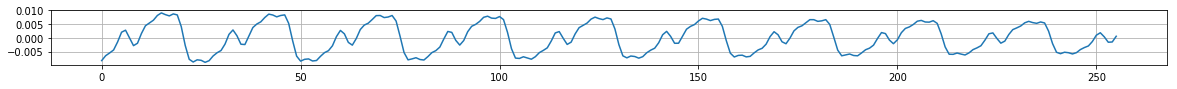

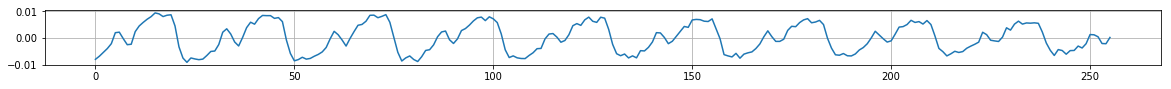

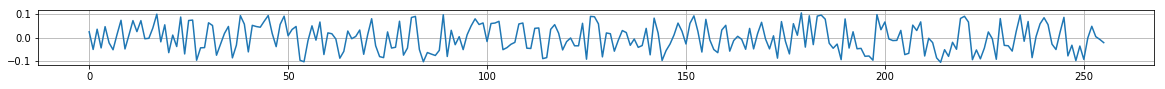

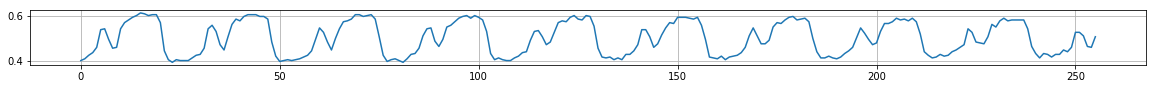

tensor([[0.4745, 1.0000, 0.0833, 0.4167],
        [0.4431, 1.0000, 0.0833, 0.4167],
        [0.4392, 1.0000, 0.0833, 0.4167],
        ...,
        [0.5176, 1.0000, 0.0833, 0.4167],
        [0.4784, 1.0000, 0.0833, 0.4167],
        [0.4588, 1.0000, 0.0833, 0.4167]])


In [9]:
#Just to visualize the audio encoding in dataloader

print("size of dataset is",len(adataset))
print("no. of steps per epoch is",len(adataset)//batch_size)

# first pick a section of audio from the dataset
samp = adataset.rand_sample()
print(samp.shape)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

#now inject noise weighted by the signal amplitude (to get roughly constant signal-to-noise ratio across data samples)
samp2 = samp + 0.1 * np.random.uniform(samp.min(), samp.max(), size=len(samp)).reshape(-1,1)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp2)), samp2) #just print one example from the batch
plt.grid()
plt.show()

#if required the noise can be fixed as well (constant=True) - see injectNoise() in transforms.py
samp3 = samp + 0.1 * np.random.uniform(-1, 1, size=len(samp)).reshape(-1,1)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp3)), samp3) #just print one example from the batch
plt.grid()
plt.show()

#we then encode the sampling to mu-law
samp_coded = audiocoding(samp2)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp_coded)), samp_coded) #just print one example from the batch
plt.grid()
plt.show()

for step, (inp,target) in enumerate(train_loader):
        print(inp[0])
        break

In [10]:
# Define the training cycle
#*************************************
def train(model,epoch):
    model.train() #put in training mode
    ave_loss_over_steps = 0
    current_loss = 10000
    
    for step, (inp,target) in enumerate(train_loader):
        inp, target = inp.to(device), target.to(device)

        # Forward + Backward + Optimize
        hidden = model.init_hidden(batch_size).to(device)
        optimizer.zero_grad()
        loss = 0
        
        for i in range(seqLen):
            use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio or i==0 else False
            #similar to Bengio et al, Scheduled Sampling for Sequence Prediction with Recurrent Neural Networks
            
            if use_teacher_forcing: #feed the target as the next input 
                outputs, hidden = model(inp[:,i,:],hidden,batch_size)  #input dim: (batch, seq, feature)
                loss += criterion(outputs, torch.squeeze(target[:,i],1))
                
                outputs = nn.functional.log_softmax(outputs,dim=1)
                topv, topi = outputs.detach().topk(1)  #choose the strongest activation detach()
                predicted_sample = targetcoding.index2float(topi)
                
            else: #feed its own predictions (output of t-1) as next input
                own_inp = inp[:,i,:].clone()
                own_inp[:,0] = torch.squeeze(torch.tensor(audiocoding(predicted_sample),
                                                          dtype=torch.float,device=device,requires_grad=True),1)
                outputs, hidden = model(own_inp,hidden,batch_size)  #input dim: (batch, seq, feature)
                loss += criterion(outputs, torch.squeeze(target[:,i],1))
                
                outputs = nn.functional.log_softmax(outputs,dim=1)
                topv, topi = outputs.detach().topk(1)  #choose the strongest activation
                predicted_sample = targetcoding.index2float(topi)
                           
        loss.backward()
        optimizer.step()
        
        ave_loss_per_sample = loss.item()/seqLen   #over each minibatch
        ave_loss_over_steps += ave_loss_per_sample
        
        if (step+1) % log_interval == 0:
            current_loss = ave_loss_over_steps/log_interval
            print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}'.format( 
                datetime.now(), epoch, num_epochs, step+1, len(adataset)//batch_size, current_loss))
            
            list_of_losses.append(current_loss)
            ave_loss_over_steps = 0
            
        if (step+1) % evaluate_interval == 0:
            result, hs = generate(model,max_length)
            plot_signal(result,start=seqLen-1)
            model.train() #put model back to training mode
        
        if savemodel_interval != 0 and savemodel:
            if (step+1) % savemodel_interval == 0:
                torch.save({ #the training parameters that will be saved
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': list_of_losses,
                'epoch': start_epoch+epoch,
                'step': start_step+step+1,
                'sample_rate': sr,
                'start_time': start,
                'datadir': datadir,
                'paramdir': paramdir,
                'savemodeldir': savemodeldir,
                'seqLen': seqLen,
                'stride': stride,
                'batch_size': batch_size,
                'num_epochs': num_epochs,
                'lr': lr,
                'log_interval': log_interval,
                'max_steps': max_steps,
                'teacher_forcing_ratio': teacher_forcing_ratio,                    
                'prop': prop,
                'output_size': output_size,
                'hidden_size': hidden_size,
                'n_layers': n_layers,
                'noise': noise,
                'lowNote': lowNote,
                'hiNote': hiNote
                },                            
                '{}/{}_{}_epoch{}_step{}.tar'.format(
                    savemodeldir,start,savename,start_epoch+epoch,start_step+step+1))
                
                print('model {}_{}_epoch{}_step{}.tar saved'.format(start,savename,start_epoch+epoch,start_step+step+1))

        
        if step==max_steps or current_loss < loss_target:
            torch.save({ #the training parameters that will be saved
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': list_of_losses,
                'epoch': start_epoch+epoch,
                'step': start_step+step+1,
                'sample_rate': sr,
                'start_time': start,
                'datadir': datadir,
                'paramdir': paramdir,
                'savemodeldir': savemodeldir,
                'seqLen': seqLen,
                'stride': stride,
                'batch_size': batch_size,
                'num_epochs': num_epochs,
                'lr': lr,
                'log_interval': log_interval,
                'max_steps': max_steps,
                'teacher_forcing_ratio': teacher_forcing_ratio,                    
                'prop': prop,
                'output_size': output_size,
                'hidden_size': hidden_size,
                'n_layers': n_layers,
                'noise': noise,
                'lowNote': lowNote,
                'hiNote': hiNote
                },                            
            '{}/{}_{}_epoch{}_step{}.tar'.format(
                savemodeldir,start,savename,start_epoch+epoch,start_step+step+1))

            print('model {}_{}_epoch{}_step{}.tar saved'.format(start,savename,start_epoch+epoch,start_step+step+1))
            break
 

 
def generate(model,max_length,primer=None,paramvect=None,returnHiddenSequence=False):
    
    hs=[] #list to save hidden states, function returns empty list if returnHiddenSequence=False 
    
    model.eval()
    with torch.no_grad():
        for p_inp,target in test_loader:
            if primer is not None:
                # must clone else primer is changed outside this function
                p_inp.data = primer.clone()
            seq = np.copy(p_inp[0,:,0])  #extract the original sample
            seq_mu = audiocoding(seq)  #mu-law
            p_inp[0,:,0] = array2tensor(torch.FloatTensor)(seq_mu) #now we have both the original and mu-lawed samples
            break  
        generated = seq
        p_inp = p_inp.to(device)

        hidden = model.init_hidden().to(device)
        if returnHiddenSequence :
            hs.append(torch.squeeze(hidden).cpu().numpy())
            
        for j in range(seqLen-1):  #build up hidden state
            _, hidden = model(p_inp[:,j,:],hidden)
        inp = p_inp[:,-1,:]  #feed the last value as the initial value of the actual generation
        
        for i in range(max_length):
            outputs, hidden = model(inp,hidden)
            outputs = nn.functional.log_softmax(outputs,dim=1)
            topv, topi = outputs.detach().topk(1)  #choose the strongest activation
            predicted_sample = targetcoding.index2float(topi)       
            generated = np.append(generated,predicted_sample)
            
            inp[:,0] = torch.from_numpy(audiocoding([predicted_sample])).type(torch.FloatTensor).to(device)

            if paramvect is not None:
                if callable(paramvect):
                    inp[:,1:] = torch.from_numpy(paramvect(i)).type(torch.FloatTensor).to(device)
                else:
                    inp[:,1:] = torch.from_numpy(paramvect).type(torch.FloatTensor).to(device)
                
            if returnHiddenSequence :
                hs.append(torch.squeeze(hidden).cpu().numpy())
                                       
        return generated, hs
        

In [11]:
# Initialize the network, optimizer and objective func
#*************************************
model = RNN(input_size=1,cond_size=cond_size,hidden_size=hidden_size,output_size=output_size,n_layers=n_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if loadmodel: # load checkpoint if needed
    print("Loading existing model and optimizer state...")
    model.load_state_dict(torch.load(loadmodelpath)['model_state_dict'])
    optimizer.load_state_dict(torch.load(loadmodelpath)['optimizer_state_dict'])
    
criterion = nn.CrossEntropyLoss()

2019-01-16 16:32:17 Starting training at epoch0 step0...
2019-01-16 16:33:02 Epoch [0/1], Step [25/12187] Loss: 5.2702
2019-01-16 16:33:46 Epoch [0/1], Step [50/12187] Loss: 4.8605
2019-01-16 16:34:29 Epoch [0/1], Step [75/12187] Loss: 4.4343
2019-01-16 16:35:10 Epoch [0/1], Step [100/12187] Loss: 4.0425


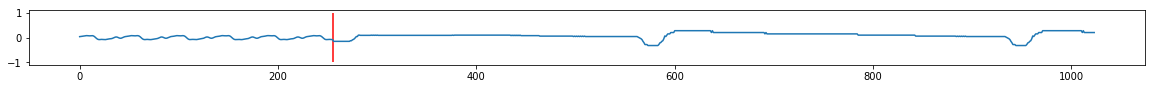

2019-01-16 16:35:54 Epoch [0/1], Step [125/12187] Loss: 3.7460
2019-01-16 16:36:37 Epoch [0/1], Step [150/12187] Loss: 3.5450
2019-01-16 16:37:22 Epoch [0/1], Step [175/12187] Loss: 3.3565
2019-01-16 16:38:06 Epoch [0/1], Step [200/12187] Loss: 3.2943


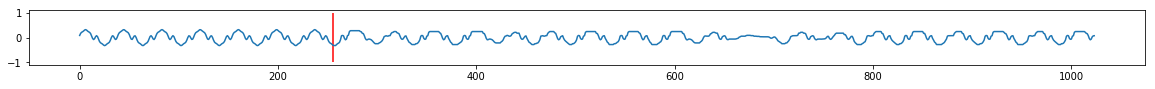

2019-01-16 16:38:52 Epoch [0/1], Step [225/12187] Loss: 3.1266
2019-01-16 16:39:37 Epoch [0/1], Step [250/12187] Loss: 3.1356
2019-01-16 16:40:20 Epoch [0/1], Step [275/12187] Loss: 3.0375
2019-01-16 16:41:02 Epoch [0/1], Step [300/12187] Loss: 2.9248


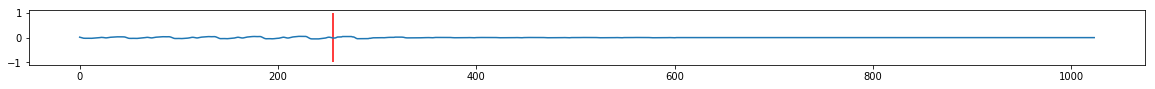

2019-01-16 16:41:47 Epoch [0/1], Step [325/12187] Loss: 2.8757
2019-01-16 16:42:26 Epoch [0/1], Step [350/12187] Loss: 2.8242
2019-01-16 16:43:08 Epoch [0/1], Step [375/12187] Loss: 2.7988
2019-01-16 16:43:52 Epoch [0/1], Step [400/12187] Loss: 2.7438


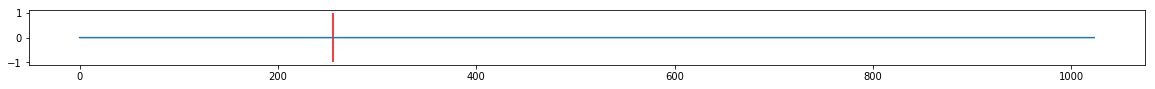

2019-01-16 16:44:39 Epoch [0/1], Step [425/12187] Loss: 2.6818
2019-01-16 16:45:22 Epoch [0/1], Step [450/12187] Loss: 2.6982
2019-01-16 16:46:05 Epoch [0/1], Step [475/12187] Loss: 2.6270
2019-01-16 16:46:47 Epoch [0/1], Step [500/12187] Loss: 2.6235


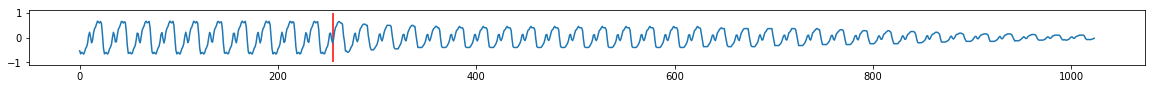

model 2019-01-16_16-32-17_model_epoch0_step500.tar saved
2019-01-16 16:47:33 Epoch [0/1], Step [525/12187] Loss: 2.6002
2019-01-16 16:48:15 Epoch [0/1], Step [550/12187] Loss: 2.5061
2019-01-16 16:48:57 Epoch [0/1], Step [575/12187] Loss: 2.4988
2019-01-16 16:49:39 Epoch [0/1], Step [600/12187] Loss: 2.4816


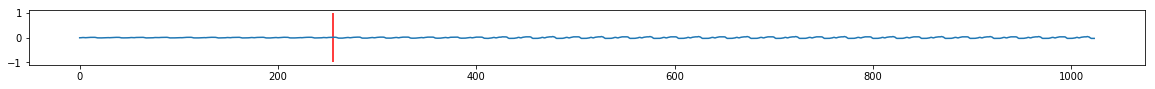

2019-01-16 16:50:24 Epoch [0/1], Step [625/12187] Loss: 2.4340
2019-01-16 16:51:06 Epoch [0/1], Step [650/12187] Loss: 2.4273
2019-01-16 16:51:48 Epoch [0/1], Step [675/12187] Loss: 2.5186
2019-01-16 16:52:31 Epoch [0/1], Step [700/12187] Loss: 2.3623


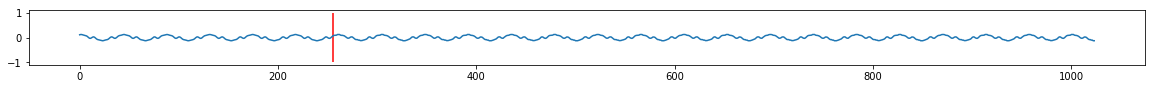

2019-01-16 16:53:16 Epoch [0/1], Step [725/12187] Loss: 2.3194
2019-01-16 16:53:58 Epoch [0/1], Step [750/12187] Loss: 2.3529
2019-01-16 16:54:39 Epoch [0/1], Step [775/12187] Loss: 2.3258
2019-01-16 16:55:21 Epoch [0/1], Step [800/12187] Loss: 2.3056


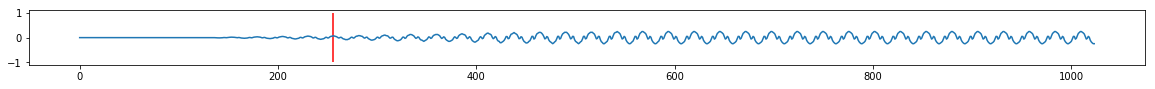

2019-01-16 16:56:07 Epoch [0/1], Step [825/12187] Loss: 2.3333
2019-01-16 16:56:51 Epoch [0/1], Step [850/12187] Loss: 2.2554
2019-01-16 16:57:31 Epoch [0/1], Step [875/12187] Loss: 2.2266
2019-01-16 16:58:12 Epoch [0/1], Step [900/12187] Loss: 2.3289


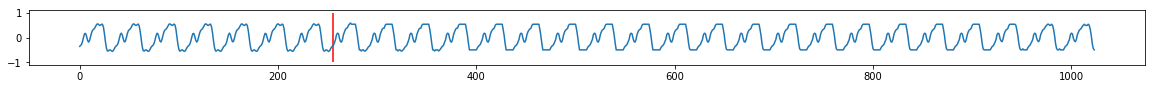

2019-01-16 16:59:01 Epoch [0/1], Step [925/12187] Loss: 2.2438
2019-01-16 16:59:47 Epoch [0/1], Step [950/12187] Loss: 2.1727
2019-01-16 17:00:30 Epoch [0/1], Step [975/12187] Loss: 2.1916
2019-01-16 17:01:12 Epoch [0/1], Step [1000/12187] Loss: 2.2773


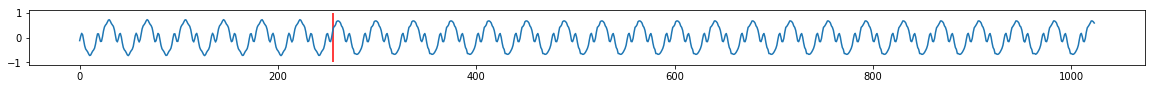

model 2019-01-16_16-32-17_model_epoch0_step1000.tar saved
2019-01-16 17:01:58 Epoch [0/1], Step [1025/12187] Loss: 2.2149
2019-01-16 17:02:40 Epoch [0/1], Step [1050/12187] Loss: 2.1631
2019-01-16 17:03:22 Epoch [0/1], Step [1075/12187] Loss: 2.1067
2019-01-16 17:04:04 Epoch [0/1], Step [1100/12187] Loss: 2.1794


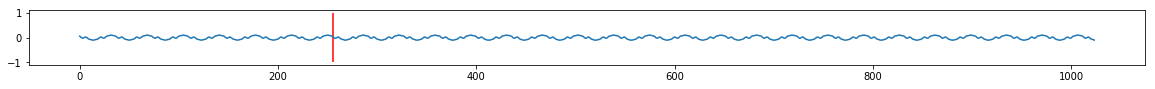

2019-01-16 17:04:49 Epoch [0/1], Step [1125/12187] Loss: 2.1416
2019-01-16 17:05:31 Epoch [0/1], Step [1150/12187] Loss: 2.1698
2019-01-16 17:06:13 Epoch [0/1], Step [1175/12187] Loss: 2.1005
2019-01-16 17:06:56 Epoch [0/1], Step [1200/12187] Loss: 2.0997


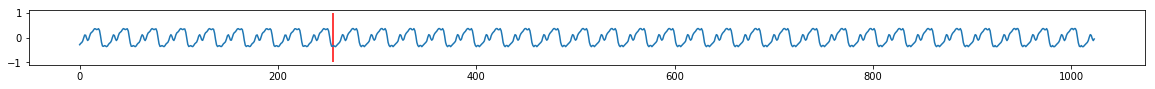

2019-01-16 17:07:42 Epoch [0/1], Step [1225/12187] Loss: 2.0419
2019-01-16 17:08:25 Epoch [0/1], Step [1250/12187] Loss: 2.0979
2019-01-16 17:09:07 Epoch [0/1], Step [1275/12187] Loss: 2.1163
2019-01-16 17:09:49 Epoch [0/1], Step [1300/12187] Loss: 2.0762


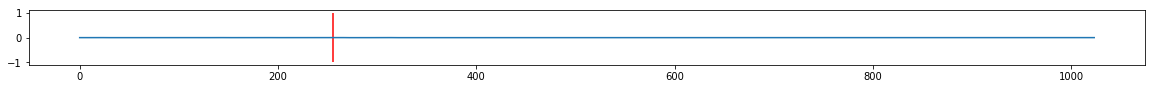

2019-01-16 17:10:34 Epoch [0/1], Step [1325/12187] Loss: 2.0404
2019-01-16 17:11:16 Epoch [0/1], Step [1350/12187] Loss: 2.0633
2019-01-16 17:11:55 Epoch [0/1], Step [1375/12187] Loss: 2.0075
2019-01-16 17:12:34 Epoch [0/1], Step [1400/12187] Loss: 2.0638


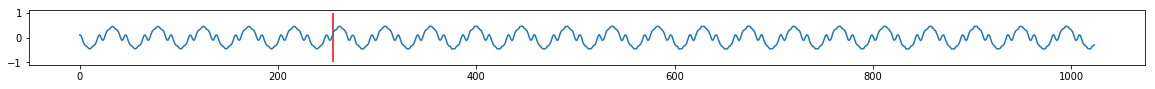

2019-01-16 17:13:17 Epoch [0/1], Step [1425/12187] Loss: 1.9997
2019-01-16 17:13:56 Epoch [0/1], Step [1450/12187] Loss: 2.0386
2019-01-16 17:14:36 Epoch [0/1], Step [1475/12187] Loss: 1.9906
2019-01-16 17:15:19 Epoch [0/1], Step [1500/12187] Loss: 2.0749


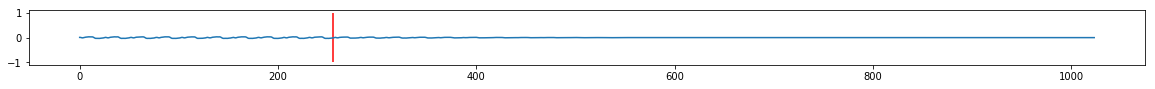

model 2019-01-16_16-32-17_model_epoch0_step1500.tar saved
2019-01-16 17:16:14 Epoch [0/1], Step [1525/12187] Loss: 1.9843
2019-01-16 17:17:00 Epoch [0/1], Step [1550/12187] Loss: 2.0467
2019-01-16 17:17:42 Epoch [0/1], Step [1575/12187] Loss: 1.9486
2019-01-16 17:18:24 Epoch [0/1], Step [1600/12187] Loss: 1.9717


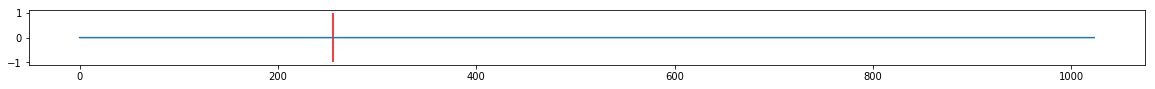

2019-01-16 17:19:11 Epoch [0/1], Step [1625/12187] Loss: 1.9448
2019-01-16 17:19:52 Epoch [0/1], Step [1650/12187] Loss: 1.9790
2019-01-16 17:20:34 Epoch [0/1], Step [1675/12187] Loss: 1.9976
2019-01-16 17:21:16 Epoch [0/1], Step [1700/12187] Loss: 1.9181


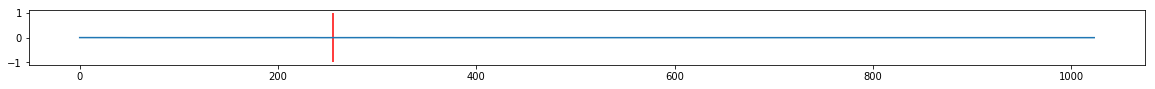

2019-01-16 17:22:02 Epoch [0/1], Step [1725/12187] Loss: 1.9518
2019-01-16 17:22:43 Epoch [0/1], Step [1750/12187] Loss: 1.9453
2019-01-16 17:23:25 Epoch [0/1], Step [1775/12187] Loss: 1.9948
2019-01-16 17:24:08 Epoch [0/1], Step [1800/12187] Loss: 1.9526


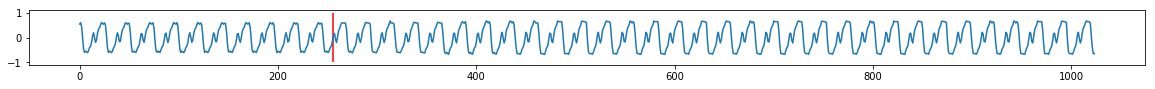

2019-01-16 17:24:54 Epoch [0/1], Step [1825/12187] Loss: 1.8861
2019-01-16 17:25:36 Epoch [0/1], Step [1850/12187] Loss: 1.9425
2019-01-16 17:26:18 Epoch [0/1], Step [1875/12187] Loss: 1.8949
2019-01-16 17:26:59 Epoch [0/1], Step [1900/12187] Loss: 1.9128


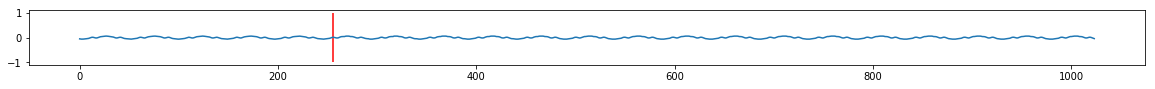

2019-01-16 17:27:41 Epoch [0/1], Step [1925/12187] Loss: 1.9325
2019-01-16 17:28:22 Epoch [0/1], Step [1950/12187] Loss: 1.8631
2019-01-16 17:29:04 Epoch [0/1], Step [1975/12187] Loss: 1.9217
2019-01-16 17:29:44 Epoch [0/1], Step [2000/12187] Loss: 1.9430


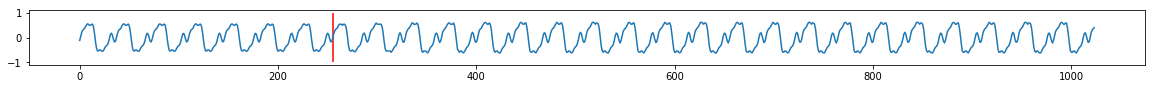

model 2019-01-16_16-32-17_model_epoch0_step2000.tar saved
2019-01-16 17:30:26 Epoch [0/1], Step [2025/12187] Loss: 1.9090
2019-01-16 17:31:07 Epoch [0/1], Step [2050/12187] Loss: 1.8583
2019-01-16 17:31:48 Epoch [0/1], Step [2075/12187] Loss: 1.8838
2019-01-16 17:32:29 Epoch [0/1], Step [2100/12187] Loss: 1.8989


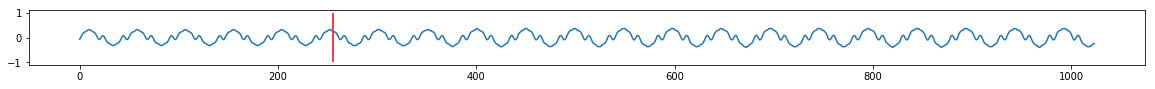

2019-01-16 17:33:16 Epoch [0/1], Step [2125/12187] Loss: 1.8400
2019-01-16 17:33:56 Epoch [0/1], Step [2150/12187] Loss: 1.8868
2019-01-16 17:34:38 Epoch [0/1], Step [2175/12187] Loss: 1.8324
2019-01-16 17:35:19 Epoch [0/1], Step [2200/12187] Loss: 1.9158


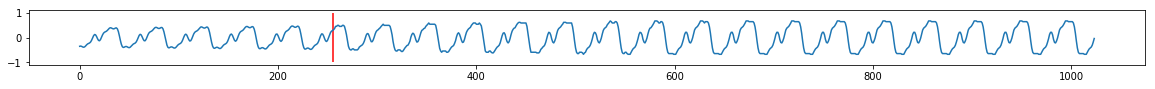

2019-01-16 17:36:05 Epoch [0/1], Step [2225/12187] Loss: 1.8659
2019-01-16 17:36:48 Epoch [0/1], Step [2250/12187] Loss: 1.8266
2019-01-16 17:37:29 Epoch [0/1], Step [2275/12187] Loss: 1.8060
2019-01-16 17:38:13 Epoch [0/1], Step [2300/12187] Loss: 1.9501


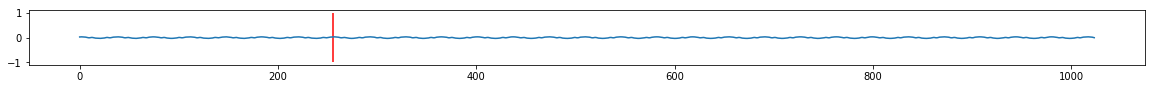

2019-01-16 17:38:58 Epoch [0/1], Step [2325/12187] Loss: 1.8692
2019-01-16 17:39:39 Epoch [0/1], Step [2350/12187] Loss: 1.8296
2019-01-16 17:40:23 Epoch [0/1], Step [2375/12187] Loss: 1.8241
2019-01-16 17:41:06 Epoch [0/1], Step [2400/12187] Loss: 1.8262


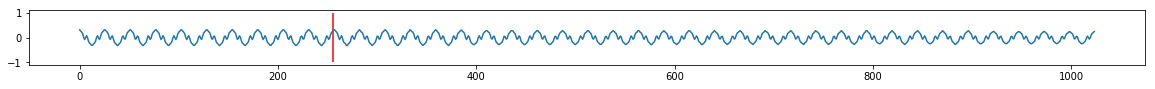

2019-01-16 17:41:49 Epoch [0/1], Step [2425/12187] Loss: 1.8023
2019-01-16 17:42:29 Epoch [0/1], Step [2450/12187] Loss: 1.8655
2019-01-16 17:43:10 Epoch [0/1], Step [2475/12187] Loss: 1.8514
2019-01-16 17:43:50 Epoch [0/1], Step [2500/12187] Loss: 1.7923


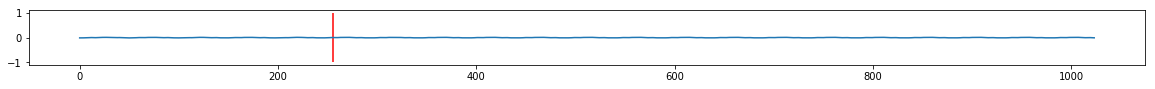

model 2019-01-16_16-32-17_model_epoch0_step2500.tar saved
2019-01-16 17:44:33 Epoch [0/1], Step [2525/12187] Loss: 1.8017
2019-01-16 17:45:13 Epoch [0/1], Step [2550/12187] Loss: 1.8374
2019-01-16 17:45:57 Epoch [0/1], Step [2575/12187] Loss: 1.7527
2019-01-16 17:46:40 Epoch [0/1], Step [2600/12187] Loss: 1.8138


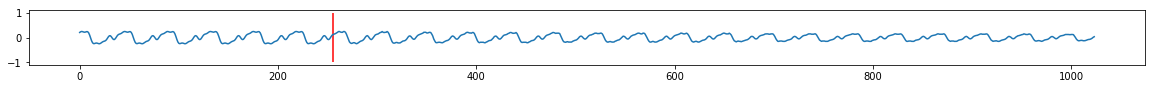

2019-01-16 17:47:26 Epoch [0/1], Step [2625/12187] Loss: 1.8136
2019-01-16 17:48:09 Epoch [0/1], Step [2650/12187] Loss: 1.8056
2019-01-16 17:48:51 Epoch [0/1], Step [2675/12187] Loss: 1.7961
2019-01-16 17:49:35 Epoch [0/1], Step [2700/12187] Loss: 1.7430


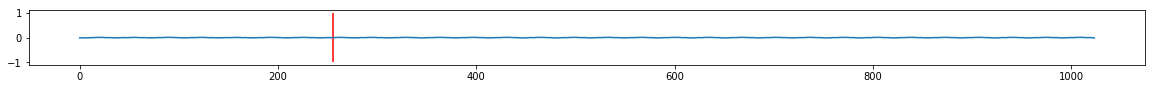

2019-01-16 17:50:20 Epoch [0/1], Step [2725/12187] Loss: 1.7909
2019-01-16 17:51:02 Epoch [0/1], Step [2750/12187] Loss: 1.8224
2019-01-16 17:51:44 Epoch [0/1], Step [2775/12187] Loss: 1.7896
2019-01-16 17:52:26 Epoch [0/1], Step [2800/12187] Loss: 1.7740


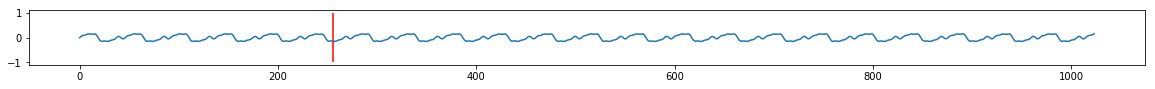

2019-01-16 17:53:11 Epoch [0/1], Step [2825/12187] Loss: 1.7811
2019-01-16 17:53:53 Epoch [0/1], Step [2850/12187] Loss: 1.7834
2019-01-16 17:54:35 Epoch [0/1], Step [2875/12187] Loss: 1.7739
2019-01-16 17:55:17 Epoch [0/1], Step [2900/12187] Loss: 1.7926


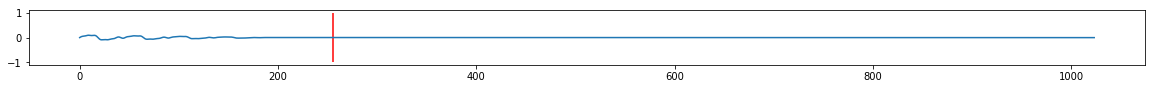

2019-01-16 17:56:02 Epoch [0/1], Step [2925/12187] Loss: 1.7392
2019-01-16 17:56:44 Epoch [0/1], Step [2950/12187] Loss: 1.7492
2019-01-16 17:57:26 Epoch [0/1], Step [2975/12187] Loss: 1.7976
2019-01-16 17:58:08 Epoch [0/1], Step [3000/12187] Loss: 1.7632


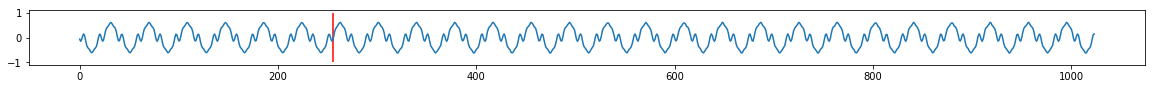

model 2019-01-16_16-32-17_model_epoch0_step3000.tar saved
2019-01-16 17:58:53 Epoch [0/1], Step [3025/12187] Loss: 1.7379
2019-01-16 17:59:35 Epoch [0/1], Step [3050/12187] Loss: 1.7220
2019-01-16 18:00:17 Epoch [0/1], Step [3075/12187] Loss: 1.7577
2019-01-16 18:00:59 Epoch [0/1], Step [3100/12187] Loss: 1.8941


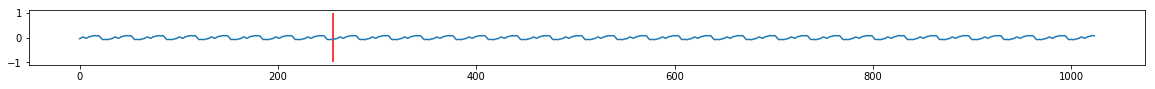

2019-01-16 18:01:44 Epoch [0/1], Step [3125/12187] Loss: 1.7865
2019-01-16 18:02:26 Epoch [0/1], Step [3150/12187] Loss: 1.7128
2019-01-16 18:03:08 Epoch [0/1], Step [3175/12187] Loss: 1.7295
2019-01-16 18:03:50 Epoch [0/1], Step [3200/12187] Loss: 1.8090


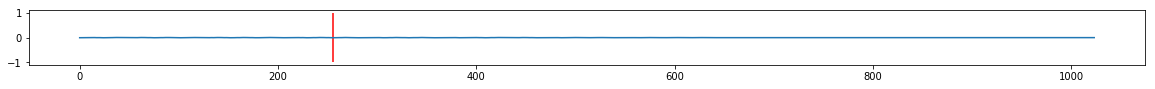

2019-01-16 18:04:35 Epoch [0/1], Step [3225/12187] Loss: 1.7226
2019-01-16 18:05:17 Epoch [0/1], Step [3250/12187] Loss: 1.7192
2019-01-16 18:05:58 Epoch [0/1], Step [3275/12187] Loss: 1.7582
2019-01-16 18:06:38 Epoch [0/1], Step [3300/12187] Loss: 1.7034


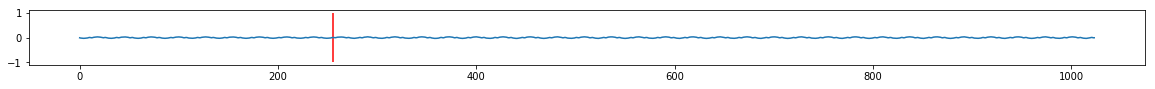

2019-01-16 18:07:22 Epoch [0/1], Step [3325/12187] Loss: 1.7451
2019-01-16 18:08:04 Epoch [0/1], Step [3350/12187] Loss: 1.6764
2019-01-16 18:08:47 Epoch [0/1], Step [3375/12187] Loss: 1.7773
2019-01-16 18:09:29 Epoch [0/1], Step [3400/12187] Loss: 1.7459


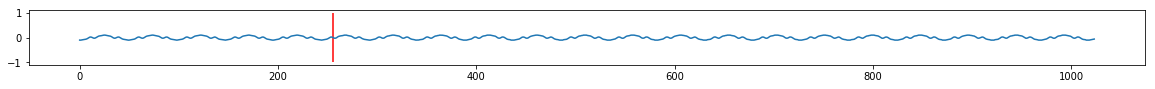

2019-01-16 18:10:15 Epoch [0/1], Step [3425/12187] Loss: 1.7123
2019-01-16 18:10:57 Epoch [0/1], Step [3450/12187] Loss: 1.6818
2019-01-16 18:11:39 Epoch [0/1], Step [3475/12187] Loss: 1.7935
2019-01-16 18:12:22 Epoch [0/1], Step [3500/12187] Loss: 1.7566


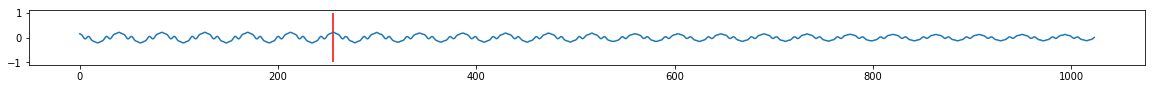

model 2019-01-16_16-32-17_model_epoch0_step3500.tar saved
2019-01-16 18:13:07 Epoch [0/1], Step [3525/12187] Loss: 1.6819
2019-01-16 18:13:49 Epoch [0/1], Step [3550/12187] Loss: 1.7206
2019-01-16 18:14:31 Epoch [0/1], Step [3575/12187] Loss: 1.6970
2019-01-16 18:15:14 Epoch [0/1], Step [3600/12187] Loss: 1.6919


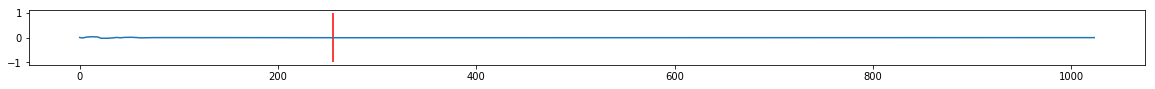

2019-01-16 18:16:00 Epoch [0/1], Step [3625/12187] Loss: 1.7519
2019-01-16 18:16:42 Epoch [0/1], Step [3650/12187] Loss: 1.7068
2019-01-16 18:17:24 Epoch [0/1], Step [3675/12187] Loss: 1.7334
2019-01-16 18:18:06 Epoch [0/1], Step [3700/12187] Loss: 1.7306


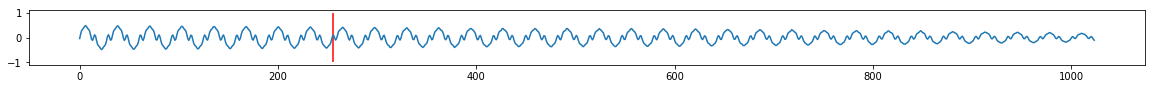

2019-01-16 18:18:52 Epoch [0/1], Step [3725/12187] Loss: 1.6911
2019-01-16 18:19:34 Epoch [0/1], Step [3750/12187] Loss: 1.6664
2019-01-16 18:20:16 Epoch [0/1], Step [3775/12187] Loss: 1.6764
2019-01-16 18:20:58 Epoch [0/1], Step [3800/12187] Loss: 1.6935


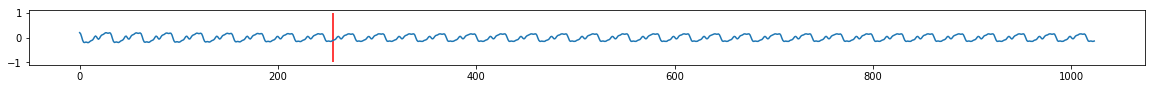

2019-01-16 18:21:44 Epoch [0/1], Step [3825/12187] Loss: 1.6493
2019-01-16 18:22:26 Epoch [0/1], Step [3850/12187] Loss: 1.6988
2019-01-16 18:23:08 Epoch [0/1], Step [3875/12187] Loss: 1.7507
2019-01-16 18:23:51 Epoch [0/1], Step [3900/12187] Loss: 1.7642


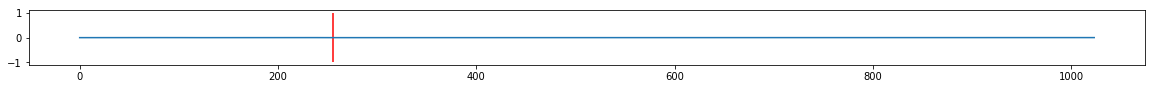

2019-01-16 18:24:37 Epoch [0/1], Step [3925/12187] Loss: 1.7247
2019-01-16 18:25:18 Epoch [0/1], Step [3950/12187] Loss: 1.6589
2019-01-16 18:25:57 Epoch [0/1], Step [3975/12187] Loss: 1.6648
2019-01-16 18:26:36 Epoch [0/1], Step [4000/12187] Loss: 1.6624


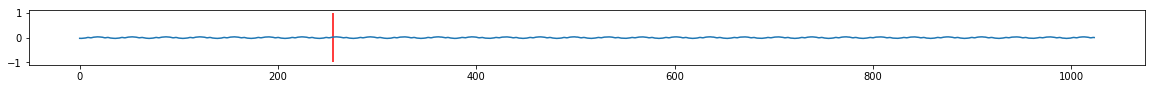

model 2019-01-16_16-32-17_model_epoch0_step4000.tar saved
2019-01-16 18:27:18 Epoch [0/1], Step [4025/12187] Loss: 1.6630
2019-01-16 18:28:03 Epoch [0/1], Step [4050/12187] Loss: 1.6925
2019-01-16 18:28:43 Epoch [0/1], Step [4075/12187] Loss: 1.6561
2019-01-16 18:29:25 Epoch [0/1], Step [4100/12187] Loss: 1.6712


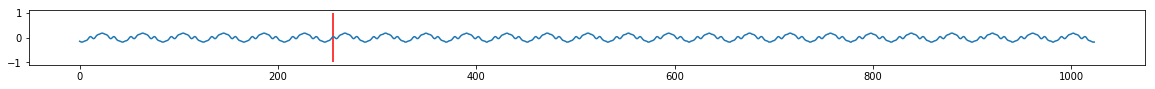

2019-01-16 18:30:08 Epoch [0/1], Step [4125/12187] Loss: 1.6733
2019-01-16 18:30:47 Epoch [0/1], Step [4150/12187] Loss: 1.6476
2019-01-16 18:31:27 Epoch [0/1], Step [4175/12187] Loss: 1.7845
2019-01-16 18:32:06 Epoch [0/1], Step [4200/12187] Loss: 1.6818


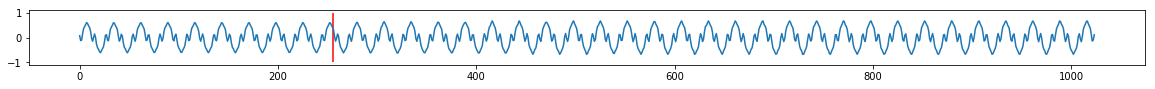

2019-01-16 18:32:50 Epoch [0/1], Step [4225/12187] Loss: 1.6713
2019-01-16 18:33:29 Epoch [0/1], Step [4250/12187] Loss: 1.6317
2019-01-16 18:34:08 Epoch [0/1], Step [4275/12187] Loss: 1.6164
2019-01-16 18:34:47 Epoch [0/1], Step [4300/12187] Loss: 1.7458


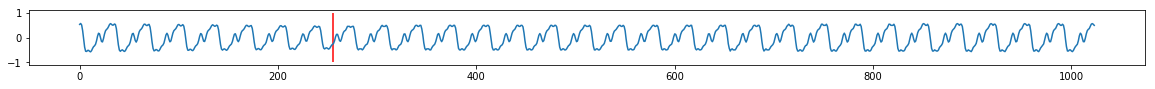

2019-01-16 18:35:30 Epoch [0/1], Step [4325/12187] Loss: 1.6374
2019-01-16 18:36:10 Epoch [0/1], Step [4350/12187] Loss: 1.6499
2019-01-16 18:36:48 Epoch [0/1], Step [4375/12187] Loss: 1.6612
2019-01-16 18:37:28 Epoch [0/1], Step [4400/12187] Loss: 1.6581


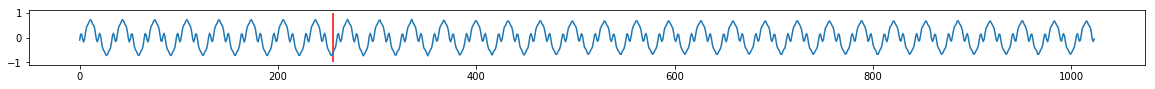

2019-01-16 18:38:10 Epoch [0/1], Step [4425/12187] Loss: 1.7012
2019-01-16 18:38:49 Epoch [0/1], Step [4450/12187] Loss: 1.6716
2019-01-16 18:39:28 Epoch [0/1], Step [4475/12187] Loss: 1.6625
2019-01-16 18:40:07 Epoch [0/1], Step [4500/12187] Loss: 1.6399


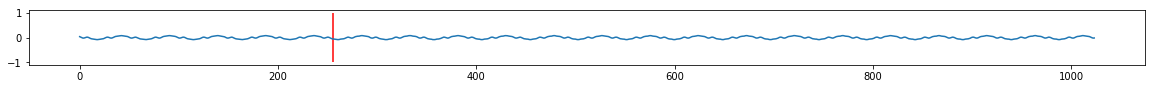

model 2019-01-16_16-32-17_model_epoch0_step4500.tar saved
2019-01-16 18:40:50 Epoch [0/1], Step [4525/12187] Loss: 1.6554
2019-01-16 18:41:29 Epoch [0/1], Step [4550/12187] Loss: 1.6419
2019-01-16 18:42:08 Epoch [0/1], Step [4575/12187] Loss: 1.7004
2019-01-16 18:42:47 Epoch [0/1], Step [4600/12187] Loss: 1.6631


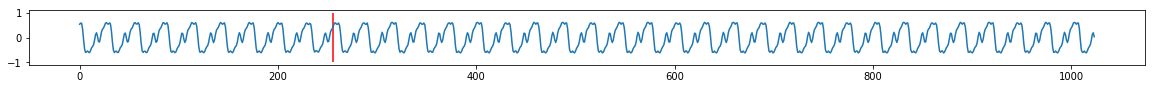

2019-01-16 18:43:30 Epoch [0/1], Step [4625/12187] Loss: 1.6065
2019-01-16 18:44:09 Epoch [0/1], Step [4650/12187] Loss: 1.6379
2019-01-16 18:44:48 Epoch [0/1], Step [4675/12187] Loss: 1.6271
2019-01-16 18:45:27 Epoch [0/1], Step [4700/12187] Loss: 1.6715


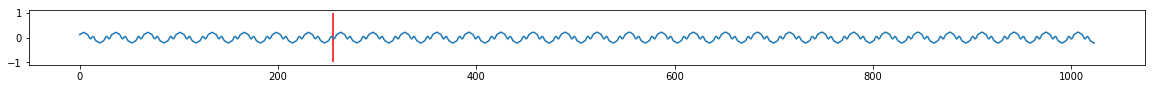

2019-01-16 18:46:09 Epoch [0/1], Step [4725/12187] Loss: 1.6226
2019-01-16 18:46:48 Epoch [0/1], Step [4750/12187] Loss: 1.6162
2019-01-16 18:47:27 Epoch [0/1], Step [4775/12187] Loss: 1.6329
2019-01-16 18:48:06 Epoch [0/1], Step [4800/12187] Loss: 1.7209


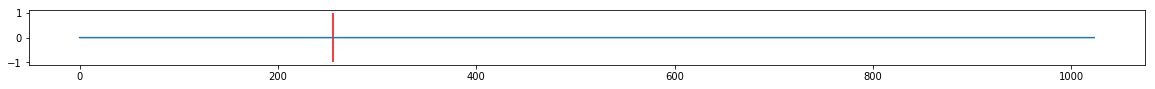

2019-01-16 18:48:49 Epoch [0/1], Step [4825/12187] Loss: 1.6199
2019-01-16 18:49:28 Epoch [0/1], Step [4850/12187] Loss: 1.6094
2019-01-16 18:50:07 Epoch [0/1], Step [4875/12187] Loss: 1.6028
2019-01-16 18:50:47 Epoch [0/1], Step [4900/12187] Loss: 1.6757


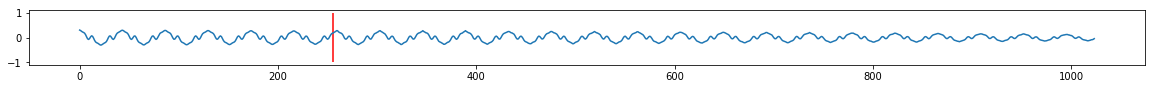

2019-01-16 18:51:29 Epoch [0/1], Step [4925/12187] Loss: 1.6237
2019-01-16 18:52:09 Epoch [0/1], Step [4950/12187] Loss: 1.5751
2019-01-16 18:52:48 Epoch [0/1], Step [4975/12187] Loss: 1.6884
2019-01-16 18:53:27 Epoch [0/1], Step [5000/12187] Loss: 1.6349


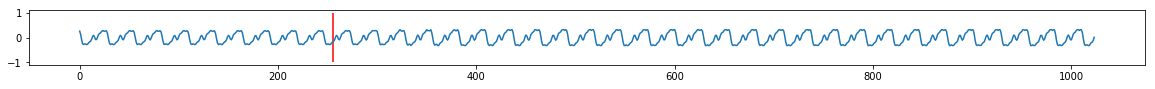

model 2019-01-16_16-32-17_model_epoch0_step5000.tar saved
2019-01-16 18:54:10 Epoch [0/1], Step [5025/12187] Loss: 1.6623
2019-01-16 18:54:49 Epoch [0/1], Step [5050/12187] Loss: 1.5852
2019-01-16 18:55:29 Epoch [0/1], Step [5075/12187] Loss: 1.6452
2019-01-16 18:56:08 Epoch [0/1], Step [5100/12187] Loss: 1.6481


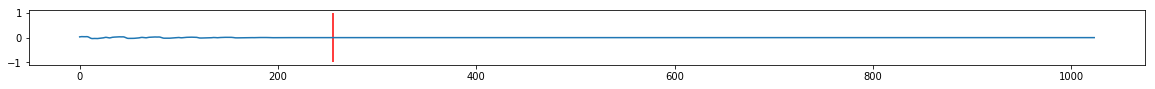

2019-01-16 18:56:50 Epoch [0/1], Step [5125/12187] Loss: 1.5957
2019-01-16 18:57:29 Epoch [0/1], Step [5150/12187] Loss: 1.6202
2019-01-16 18:58:08 Epoch [0/1], Step [5175/12187] Loss: 1.6118
2019-01-16 18:58:47 Epoch [0/1], Step [5200/12187] Loss: 1.6334


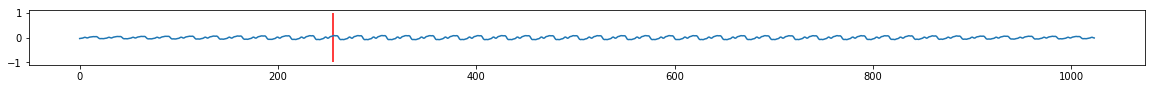

2019-01-16 18:59:29 Epoch [0/1], Step [5225/12187] Loss: 1.5883
2019-01-16 19:00:08 Epoch [0/1], Step [5250/12187] Loss: 1.5866
2019-01-16 19:00:47 Epoch [0/1], Step [5275/12187] Loss: 1.7113
2019-01-16 19:01:26 Epoch [0/1], Step [5300/12187] Loss: 1.6337


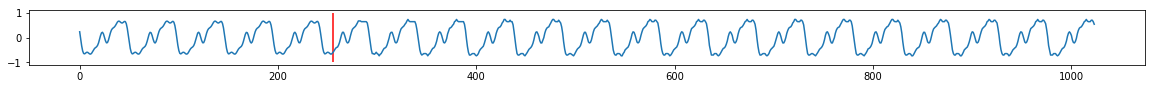

2019-01-16 19:02:08 Epoch [0/1], Step [5325/12187] Loss: 1.6206
2019-01-16 19:02:47 Epoch [0/1], Step [5350/12187] Loss: 1.6832
2019-01-16 19:03:26 Epoch [0/1], Step [5375/12187] Loss: 1.5825
2019-01-16 19:04:05 Epoch [0/1], Step [5400/12187] Loss: 1.5647


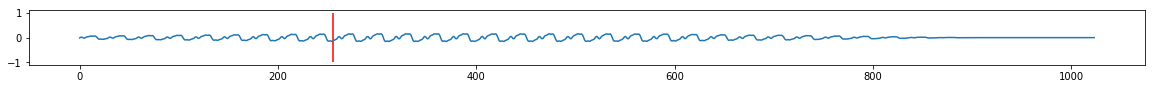

2019-01-16 19:04:47 Epoch [0/1], Step [5425/12187] Loss: 1.5650
2019-01-16 19:05:26 Epoch [0/1], Step [5450/12187] Loss: 1.5687
2019-01-16 19:06:05 Epoch [0/1], Step [5475/12187] Loss: 1.7040
2019-01-16 19:06:44 Epoch [0/1], Step [5500/12187] Loss: 1.8940


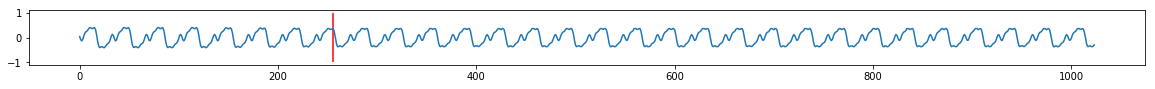

model 2019-01-16_16-32-17_model_epoch0_step5500.tar saved
2019-01-16 19:07:26 Epoch [0/1], Step [5525/12187] Loss: 1.5731
2019-01-16 19:08:05 Epoch [0/1], Step [5550/12187] Loss: 1.5608
2019-01-16 19:08:44 Epoch [0/1], Step [5575/12187] Loss: 1.5343
2019-01-16 19:09:27 Epoch [0/1], Step [5600/12187] Loss: 1.5715


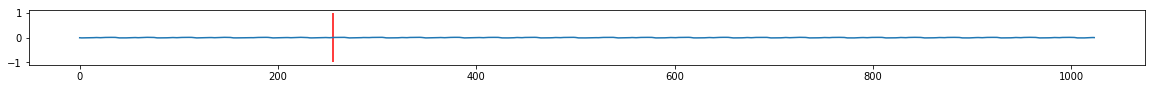

2019-01-16 19:10:10 Epoch [0/1], Step [5625/12187] Loss: 1.5841
2019-01-16 19:10:49 Epoch [0/1], Step [5650/12187] Loss: 1.5665
2019-01-16 19:11:28 Epoch [0/1], Step [5675/12187] Loss: 1.6051
2019-01-16 19:12:06 Epoch [0/1], Step [5700/12187] Loss: 1.5988


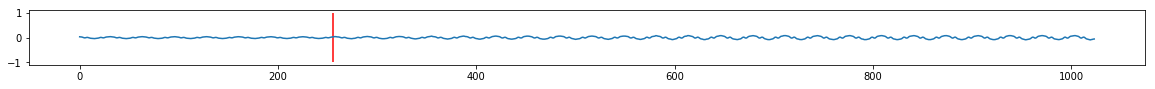

2019-01-16 19:12:48 Epoch [0/1], Step [5725/12187] Loss: 1.6298
2019-01-16 19:13:27 Epoch [0/1], Step [5750/12187] Loss: 1.5765
2019-01-16 19:14:06 Epoch [0/1], Step [5775/12187] Loss: 1.5759
2019-01-16 19:14:44 Epoch [0/1], Step [5800/12187] Loss: 1.6728


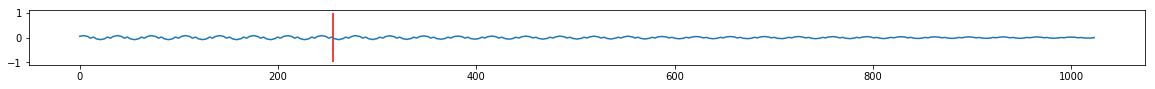

2019-01-16 19:15:26 Epoch [0/1], Step [5825/12187] Loss: 1.5703
2019-01-16 19:16:05 Epoch [0/1], Step [5850/12187] Loss: 1.5987
2019-01-16 19:16:44 Epoch [0/1], Step [5875/12187] Loss: 1.5283
2019-01-16 19:17:23 Epoch [0/1], Step [5900/12187] Loss: 1.5670


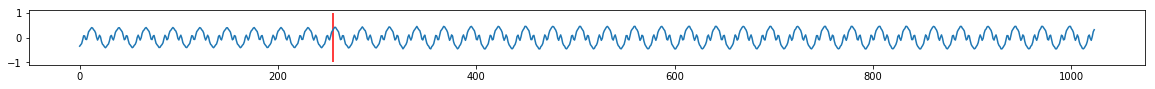

2019-01-16 19:18:05 Epoch [0/1], Step [5925/12187] Loss: 1.5806
2019-01-16 19:18:44 Epoch [0/1], Step [5950/12187] Loss: 1.5772
2019-01-16 19:19:22 Epoch [0/1], Step [5975/12187] Loss: 1.5508
2019-01-16 19:20:01 Epoch [0/1], Step [6000/12187] Loss: 1.5809


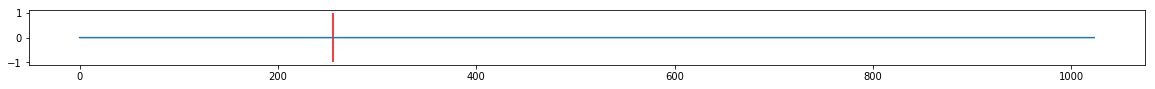

model 2019-01-16_16-32-17_model_epoch0_step6000.tar saved
model 2019-01-16_16-32-17_model_epoch0_step6001.tar saved
Training time taken: 2:47:48


In [12]:
# Train!
#*************************************
if not loadTrainingParams:
    start = '{:%Y-%m-%d_%H-%M-%S}'.format(datetime.now())
print('{:%Y-%m-%d %H:%M:%S} Starting training at epoch{} step{}...'.format(datetime.now(),start_epoch,start_step))
start_time = time.monotonic()
for epoch in range(num_epochs):
    train(model,epoch)
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))

if savemodel_interval == 0 and savemodel: #!NOTE the naming scheme for this saving part in still incorrect (for steps) 
    torch.save({#the checkpoint_dict here is slightly different from above since it can't access some local variables in training
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': list_of_losses,
                            'epoch': start_epoch+epoch,
                            'step': start_step,
                            'sample_rate': sr,
                            'start_time': start,
                            'datadir': datadir,
                            'paramdir': paramdir,
                            'savemodeldir': savemodeldir,
                            'seqLen': seqLen,
                            'stride': stride,
                            'batch_size': batch_size,
                            'num_epochs': num_epochs,
                            'lr': lr,
                            'log_interval': log_interval,
                            'max_steps': max_steps,
                            'teacher_forcing_ratio': teacher_forcing_ratio,                    
                            'prop': prop,
                            'output_size': output_size,
                            'hidden_size': hidden_size,
                            'n_layers': n_layers,
                            'noise': noise,
                            'lowNote': lowNote,
                            'hiNote': hiNote
                },                            
                    '{}/{}_{}_epoch{}_step{}.tar'.format(
                        savemodeldir,start,savename,start_epoch+epoch,start_step))
    print('model {}_{}_epoch{}_step{}.tar saved'.format(start,savename,start_epoch+epoch,start_step))

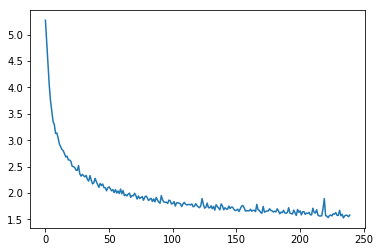

In [13]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)